# ブラインド等化：CMA (Constant Modulus Algorithm)

このセクションでは、現代のデジタル通信（無線・光通信）において最も広く利用されているブラインド等化アルゴリズムである **CMA (Constant Modulus Algorithm: 定振幅アルゴリズム)** を実装します。

CMAは、1980年にGodard、1983年にTreichlerらによって独立に提案されました。送信信号の振幅（Modulus）が一定、または特定の統計量に集約されるという性質を利用して、参照信号なしに符号間干渉（ISI）を除去します。

## 1. 信号の生成 (Generation of Source and Received Signals)
まずは、送信側で生成された **Source Symbols (4-PAM)** が通信路を通り、符号間干渉 (ISI) と観測雑音の影響を受けた **Received Signal (受信信号)** を作成します。

> CMAは本来PSKなどの定振幅信号で特に自然に働く手法だが、本ノートでは4-PAMに対しても分散パラメータ $R_2$ を用いて挙動を観察する。

In [7]:
# @title 1. Generation of Source and Received Signals (4-PAM and Multipath Channel) { run: "auto" }
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.titlesize": 18,
    "axes.titlesize": 16,
    "axes.labelsize": 15,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

# --- System Parameters ---
N_samples = 10000    # Number of total samples
noise_var = 0.005    # Variance of additive white Gaussian noise (AWGN)

np.random.seed(42)

# 1. Generate Source Symbols (s_source) using 4-PAM: {-3, -1, 1, 3}
source_levels = np.array([-3, -1, 1, 3])
s_source = np.random.choice(source_levels, N_samples)

# 2. Define a dispersive multipath channel (causes Inter-Symbol Interference)
h_channel = np.array([0.5, 1.0, -0.3, 0.1, -0.05])

# 3. Generate Received Signal (x_received)
# This is the input to the equalizer
x_received = np.convolve(s_source, h_channel, mode='full')[:N_samples]
x_received += np.sqrt(noise_var) * np.random.randn(N_samples)

print(f"Successfully generated {N_samples} samples.")
print(f"Source: 4-PAM {source_levels} | Channel taps: {h_channel}")

Successfully generated 10000 samples.
Source: 4-PAM [-3 -1  1  3] | Channel taps: [ 0.5   1.   -0.3   0.1  -0.05]


## 2. CMAの理論と実行 (CMA Execution)
CMAは、等化出力 **Equalized Output** $y(n)$ の二乗振幅と、分散パラメータ $R_2$ との差を最小化するように動作します。コスト関数 $J_{CMA}$ は以下のように定義されます。

$$J_{CMA} = E\left[ \frac{1}{4} (|y(n)|^2 - R_2)^2 \right]$$

フィルタの更新式は以下の通りです。

$$e_{CMA}(n) = y(n) (|y(n)|^2 - R_2)$$
$$\mathbf{w}(n+1) = \mathbf{w}(n) - \mu e_{CMA}(n) \mathbf{x}(n)$$

ここで、$R_2$ は送信信号の統計量から決まる定数（Constant Modulus）です。
$$R_2 = \frac{E[|s(n)|^4]}{E[|s(n)|^2]}$$
4-PAM（$\{-3, -1, 1, 3\}$）の場合、$R_2 = 8.2$ となります。

### 学習の評価指標：残存ISI (Residual ISI)
Satoアルゴリズムと同様に、通信路 $\mathbf{h}$ と等化器 $\mathbf{w}(n)$ の合成インパルス応答 $\mathbf{g}(n) = \mathbf{h} * \mathbf{w}(n)$ を用いて、符号間干渉がどれだけ除去されているかをdB単位で評価します。

$$\text{ISI}(n) = 10 \log_{10} \left( \frac{\sum_k |g_k(n)|^2 - \max_k |g_k(n)|^2}{\max_k |g_k(n)|^2} \right) \quad \text{[dB]}$$

In [8]:
# @title 2. CMA Execution (Equalization) { run: "auto" }

# @markdown ### 🔽 Algorithm Parameters
# Note: CMA is sensitive to the step-size.
mu_cma = 0.0002  # @param {type:"slider", min:0.00001, max:0.001, step:0.00001}
n_taps = 15      # @param {type:"slider", min:5, max:31, step:2}

print("Running CMA for adaptive equalization...")

def run_cma_equalization(
    x_received: np.ndarray,
    h_channel: np.ndarray,
    source_levels: np.ndarray,
    mu: float = 0.0002,
    n_taps: int = 15,
    init: str = "center",
) -> tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    CMA blind equalization (real-valued version).
    Returns:
        y_equalized     : equalized output
        isi_history_db  : residual ISI in dB
        w_equalizer     : final equalizer weights
        r2              : CMA dispersion constant R2
    """
    N = len(x_received)

    # CMA constant: R2 = E[|s|^4] / E[|s|^2]
    s = source_levels.astype(float)
    r2 = np.mean(np.abs(s)**4) / (np.mean(np.abs(s)**2) + 1e-12)

    # Initialize equalizer
    w_equalizer = np.zeros(n_taps, dtype=float)
    if init == "center":
        w_equalizer[n_taps // 2] = 1.0
    elif init == "first":
        w_equalizer[0] = 1.0
    else:
        raise ValueError("init must be 'center' or 'first'")

    y_equalized = np.zeros(N, dtype=float)
    isi_history_db = np.zeros(N, dtype=float)

    for n in range(n_taps, N):
        x_vec = x_received[n:n - n_taps:-1]

        # 1) Filtering
        y = np.dot(w_equalizer, x_vec)
        y_equalized[n] = y

        # 2) CMA error (real-valued case: |y|^2 = y^2)
        e = y * (y**2 - r2)

        # 3) Update
        w_equalizer -= mu * e * x_vec

        # 4) Residual ISI from combined impulse response g = h * w
        g_combined = np.convolve(h_channel, w_equalizer)
        g2 = np.abs(g_combined)**2
        max_g2 = np.max(g2)
        isi = (np.sum(g2) - max_g2) / (max_g2 + 1e-12)
        isi_history_db[n] = 10.0 * np.log10(isi + 1e-12)

    isi_history_db[:n_taps] = isi_history_db[n_taps]
    return y_equalized, isi_history_db, w_equalizer, r2


y_equalized, isi_history_db, w_equalizer, r2 = run_cma_equalization(
    x_received=x_received,
    h_channel=h_channel,
    source_levels=source_levels,
    mu=mu_cma,
    n_taps=n_taps,
    init="center",
)

print(f"Algorithm execution completed. R2={r2:.4f}")

Running CMA for adaptive equalization...
Algorithm execution completed. R2=8.2000


## 3. 結果の可視化と信号分布の比較 (Final Visualization)

ブラインド等化（CMA）の成果を評価するため、以下の2つの視点でグラフを表示します。

### 1. 信号分布の比較（上段）

等化器に入る前の **Received Signal（受信信号）** と、収束後の **Equalized Output（等化出力）** の確率密度関数 (PDF) を比較します。

* **Received Signal（グレー）**: 通信路による畳み込み歪み（ISI）によって、本来の4つのシンボルが重なり合い、閾値判定は不可能な状態です。
* **Equalized Output（緑）**: CMAによって振幅のモーメント構造が整えられ、ISIが抑圧されます。その結果、理想的な **Source Symbols** のレベル（赤点線）付近にピークが形成されます。

CMAは振幅を直接「判定」するのではなく、出力の2次および4次モーメントを整えることで分布構造を回復させる点が特徴です。

---

### 2. 残存ISIの学習曲線（下段）

アルゴリズムが「符号間干渉をどれだけ削ぎ落としたか」をデシベル単位で示します。

* **Residual ISI [dB]**: 合成インパルス応答 $\mathbf{g}(n) = \mathbf{h} * \mathbf{w}(n)$ に基づくエネルギー比を用いて評価しています。
* **実用的な目標値（Practical Target）**: $-20$ dB のガイドラインを設けています。これは理論値ではなく、この環境下で安定してシンボル判定が可能になる一つの目安です。

---

> ⚠️ **注意（ブラインド等化の不定性）**  
> ブラインド等化は原理的に「スケール・符号・遅延」の不定性を持ちます。  
> そのため、等化後のピークが理想レベル（例：±1, ±3）と完全に一致しない場合があります。

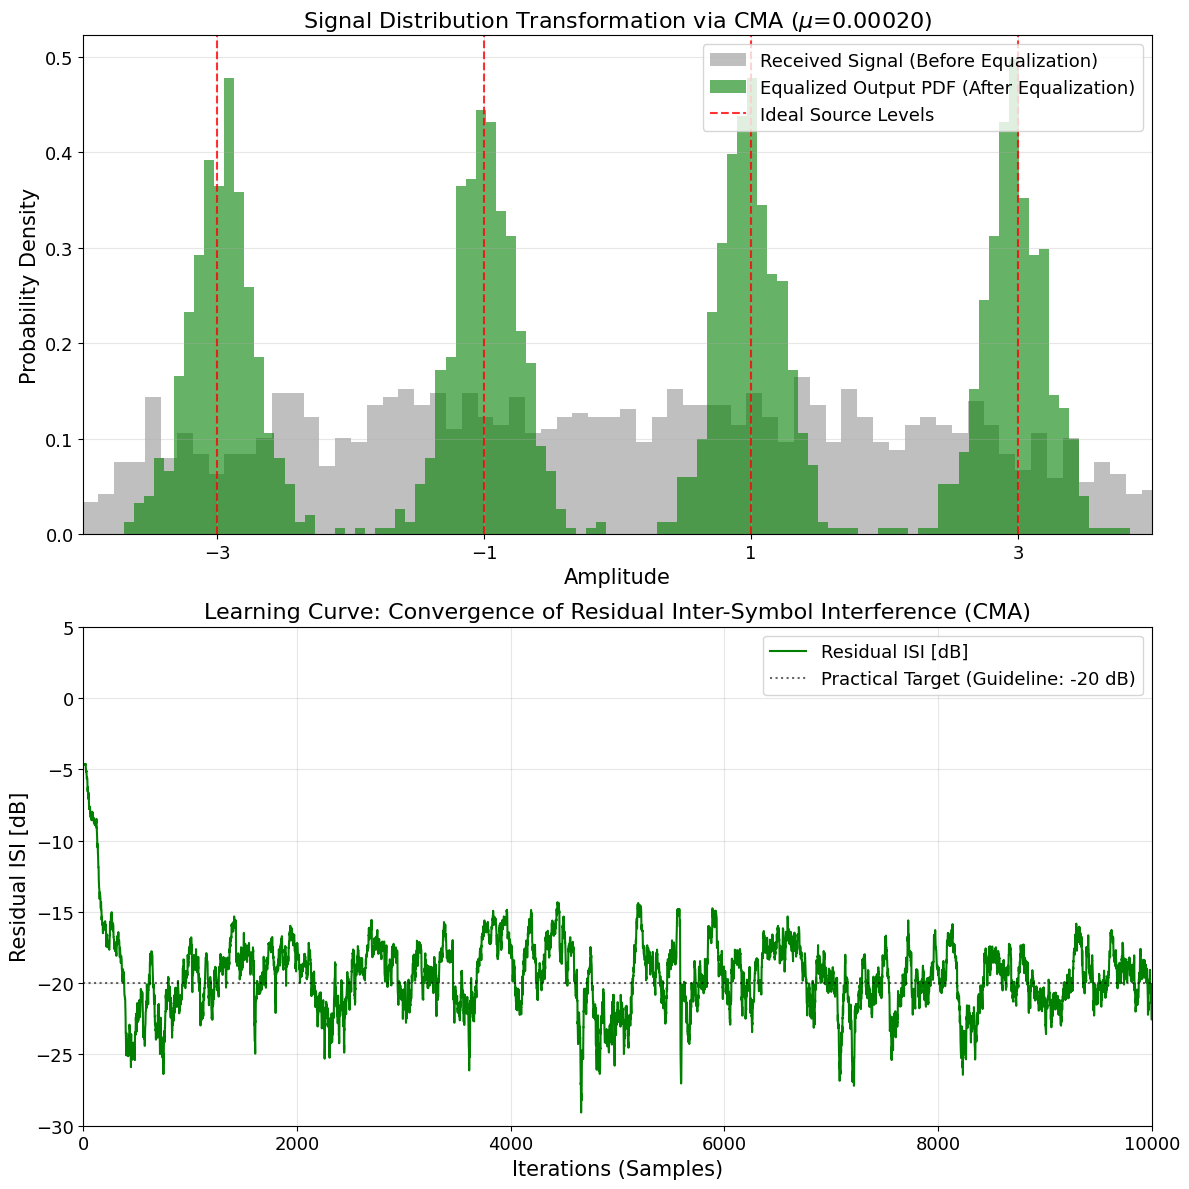

In [9]:
# @title 3. Final Visualization (Distributions + Residual ISI) { run: "auto" }

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

analysis_samples = 2000
dist_received = x_received[:analysis_samples]
dist_equalized = y_equalized[-analysis_samples:]

ax1.hist(dist_received, bins=100, color='gray', alpha=0.5, density=True,
         label='Received Signal (Before Equalization)')
ax1.hist(dist_equalized, bins=100, color='green', alpha=0.6, density=True,
         label=f'Equalized Output PDF (After Equalization)')

for i, level in enumerate(source_levels):
    ax1.axvline(level, color='red', linestyle='--', alpha=0.8,
                label='Ideal Source Levels' if i == 0 else "")

ax1.set_title(rf'Signal Distribution Transformation via CMA ($\mu$={mu_cma:.5f})')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Probability Density')
ax1.set_xlim([-6, 6])
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

levels = np.sort(source_levels)
margin = 1.0
ax1.set_xlim([levels[0] - margin, levels[-1] + margin])
ax1.set_xticks(levels)

ax2.plot(np.arange(N_samples), isi_history_db, color='green', linewidth=1.5, label='Residual ISI [dB]')
ax2.axhline(-20, color='black', linestyle=':', alpha=0.6, label='Practical Target (Guideline: -20 dB)')

ax2.set_title('Learning Curve: Convergence of Residual Inter-Symbol Interference (CMA)')
ax2.set_xlabel('Iterations (Samples)')
ax2.set_ylabel('Residual ISI [dB]')
ax2.set_xlim([0, N_samples])
ax2.set_ylim([-30, 5])
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 【補足1】Pseudo-Constellation（Delay Embedding）の見方（CMA）

複素ベースバンド信号では通常 I-Q 平面にコンスタレーションを描きますが、
本デモは実数の 4-PAM 信号であるため、そのままでは 2 次元表示になりません。

そこで、受信信号 $x[n]$ または等化出力 $y[n]$ を 1 サンプル遅延させた
$(x[n],\, x[n-1])$ や $(y[n],\, y[n-1])$ を平面上にプロットし、
2 次元の「擬似コンスタレーション（delay embedding）」として可視化しています。

---

#### ■ 左図：Before CMA（等化前）

左図は受信信号 $x[n]$ に対する擬似コンスタレーションです。

点群が斜め方向に伸びた帯状構造になっていることから、

- 通信路による畳み込み歪み（ISI）が存在する
- $x[n]$ と $x[n-1]$ の間に強い相関がある

ことが分かります。

理想的な 4-PAM 信号であれば離散的な値しか取りませんが、
チャネル歪みによりサンプル間が混ざることで、
散布図は連続的に広がった「雲」のような形になります。

---

#### ■ 右図：After CMA（等化後）

右図は等化出力 $y[n]$ に対する擬似コンスタレーションです。

点群が格子状に分離し、
明確な $4 \times 4 = 16$ 個のクラスタが形成されています。

これは、CMA によって

- 合成インパルス応答 $\mathbf{g}(n) = \mathbf{h} * \mathbf{w}(n)$ が
  デルタ関数に近づき、
- ISI が抑圧された

ことを視覚的に示しています。

等化が進むと $y[n]$ は再び
$\{-3,-1,1,3\}$ に対応する離散値の近傍を取り、
その結果 $(y[n],\, y[n-1])$ の組み合わせは
16 通りの点付近に集中します。

---

#### ■ CMA における特徴

Sato アルゴリズムと異なり、CMA は
出力振幅のモーメント構造（$E[|y|^2]$ および $E[|y|^4]$）を利用します。

そのため、

- 分布のエネルギー構造を整える方向に適応が進み、
- その結果として ISI が減少し、クラスタ構造が形成される

という挙動が現れます。

ここで重要なのは、
クラスタの位置が理想レベルと完全一致することではなく、
**クラスタが形成されること自体が ISI 低減を示す指標である**
という点です。

---

この図は、
「相関を持つ連続的な分布が、構造を持つ離散的な分布へと変換される」
過程を直感的に示しています。

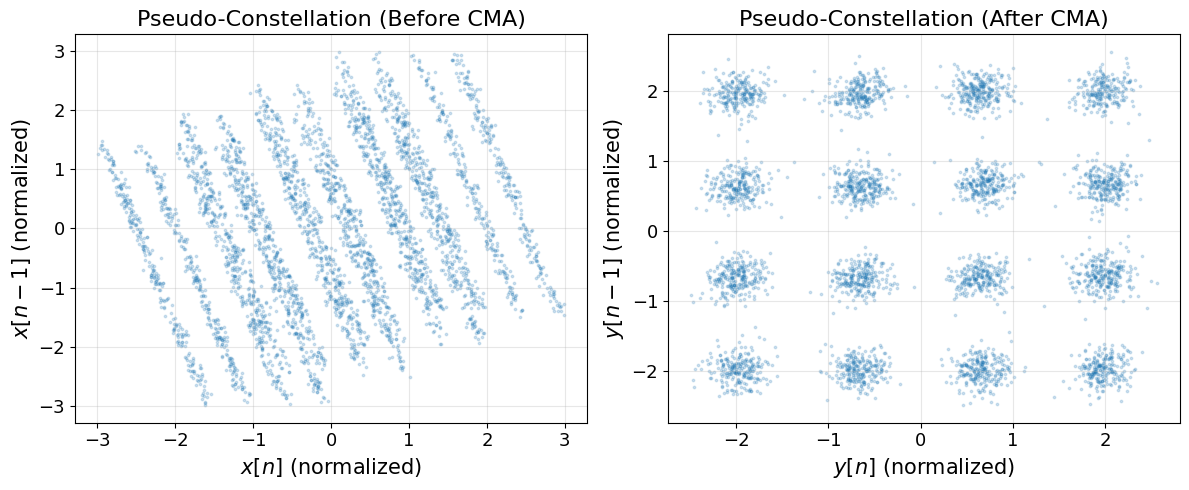

In [10]:
# --- Pseudo-constellation (CMA): Before vs After ---

def delay_embedding(z):
    return z[1:], z[:-1]

plot_samples = 4000

z_received = x_received[:plot_samples]
z_equalized = y_equalized[-plot_samples:]

# Robust normalization (scale ambiguity)
def robust_normalize(z):
    s = np.median(np.abs(z))
    return z / (s + 1e-12)

z_received_n = robust_normalize(z_received)
z_equalized_n = robust_normalize(z_equalized)

xr, yr = delay_embedding(z_received_n)
xe, ye = delay_embedding(z_equalized_n)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(xr, yr, s=3, alpha=0.2)
axes[0].set_title("Pseudo-Constellation (Before CMA)")
axes[0].set_xlabel("$x[n]$ (normalized)")
axes[0].set_ylabel("$x[n-1]$ (normalized)")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(xe, ye, s=3, alpha=0.2)
axes[1].set_title("Pseudo-Constellation (After CMA)")
axes[1].set_xlabel("$y[n]$ (normalized)")
axes[1].set_ylabel("$y[n-1]$ (normalized)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 【補足2】CMAは定振幅信号向けなのに、なぜ4-PAMにも適用できるのか？

CMA（Constant Modulus Algorithm）は本来、PSKのような
**定振幅（定包絡線）信号**を対象としたブラインド等化法です。
理想的なPSK信号では $|s(n)|$ は一定であり、
コスト関数

$$
J_{\text{CMA}} = E\left[(|y(n)|^2 - R_2)^2\right]
$$

は「出力振幅を一定値に保つ」ことを目的としています。

---

#### ■ 4-PAMでは何が起きるのか？

4-PAM信号では振幅は $\{1,3\}$ のように複数の値をとるため、
厳密な意味での「定振幅信号」ではありません。
ここで重要なのは、CMAが最小化しようとしている量が

$$
|y(n)|^2
$$

の“ばらつき”であるという点です。

CMAで用いる分散パラメータ $R_2$ は

$$
R_2 = \frac{E[|s(n)|^4]}{E[|s(n)|^2]}
$$

で定義されます。
4-PAMの場合、

$$
E[|s|^2] = 5, \qquad
E[|s|^4] = 41
$$

なので

$$
R_2 = \frac{41}{5} = 8.2
$$

となります。
つまりCMAは、

$$
|y(n)|^2 \approx 8.2
$$

となるように適応を進めるアルゴリズムです。

---

#### ■ それでも多値が復元される理由

4-PAMでは $|s|^2$ は

$$
1^2 = 1, \qquad 3^2 = 9
$$

の2値を取ります。
その平均的な“重心”が

$$
E[|s|^2] = 5
$$

であり、さらに4次モーメントとの比で決まる $R_2=8.2$ は、
振幅のエネルギー分布の特徴量を表しています。
CMAは出力を完全に一定振幅に固定するのではなく、

- 出力エネルギーの分散を減らす
- 極端に小さい値や大きすぎる値を抑える

方向に更新します。

その結果、

- ISIによって連続的に広がっていた分布が整理され
- 本来の $\{-3,-1,1,3\}$ に対応する離散クラスタへ収束していきます。

---

#### ■ 本質的な理解

CMAは「定振幅信号専用のアルゴリズム」というよりも、

> 振幅のモーメント構造（特に2次・4次モーメント）を
> 利用して分布形状を整えるブラインド適応法

と理解する方が本質に近いと言えます。

そのため、4-PAMのような非定振幅信号に対しても、
完全な定振幅にはならないものの、
ISIが抑圧される方向へ自然に収束する挙動が観察されます。

### 【補足3】CMAのありがたみ：Satoアルゴリズムとの違い  
CMAはSatoアルゴリズムをより一般化した手法と言えます。Satoアルゴリズムが信号の「符号（sgn）」のみを利用していたのに対し、CMAは「二乗振幅（パワー）」を利用します。

1.  **高次統計量の利用**: CMAは信号の4次統計量（Kurtosisなど）を暗黙的に利用しており、Satoアルゴリズムよりも定常状態でのISI（誤差）を小さく抑えられる傾向があります。
2.  **位相への不感性**: CMAのコスト関数は「振幅」のみに依存するため、受信信号にキャリア位相の回転（フェーズオフセット）があっても、その影響を受けずに等化を遂行できるという強力な特性を持っています。
3.  **汎用性**: この性質から、QAMなどのより複雑な変調方式にも容易に拡張でき、現代のデジタル通信におけるブラインド等化のデファクトスタンダードとなっています。

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>